In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

import catboost
print('catboost version:', catboost.__version__)
from catboost import CatBoostClassifier 

catboost version: 1.0.5


In [2]:
data = pd.read_csv("games.csv")

In [3]:
data.drop(["created_at","white_id","black_id","last_move_at","moves","id","opening_name","victory_status"], axis = 1, inplace = True)
data["rating_difference"]=data["white_rating"]-data["black_rating"]
data["winner"] = data["winner"].apply(lambda x: 1 if x=='white' else 0 if x=='black' else 0.5)
data["average_rating"]=(data["white_rating"]+data["black_rating"])/2
data.drop(["white_rating","black_rating"], axis = 1, inplace = True)
data['opening_eco'] = [ln[0:2] for ln in data['opening_eco'].values]
data.head()

,rated,turns,winner,increment_code,opening_eco,opening_ply,rating_difference,average_rating
0,False,13,1.0,15+2,D1,5,309,1345.5
1,True,16,0.0,5+10,B0,4,61,1291.5
2,True,61,1.0,5+10,C2,3,-4,1498.0
3,True,61,1.0,20+0,D0,3,-15,1446.5
4,True,95,1.0,30+3,C4,5,54,1496.0


In [4]:
data["increment_code"]= data["increment_code"].str.split("+",n=1,expand=True)
data["increment_code"]=data["increment_code"].astype(int)
data["increment_code"] = data["increment_code"].apply(lambda x: 1 if x<6 else 2 if x<16 else 3)
data["rating_difference"]=data["rating_difference"].astype(float)
data["turns"]=data["turns"].astype(float)
data["opening_ply"]=data["opening_ply"].astype(float)

In [5]:
data.head()

,rated,turns,winner,increment_code,opening_eco,opening_ply,rating_difference,average_rating
0,False,13.0,1.0,2,D1,5.0,309.0,1345.5
1,True,16.0,0.0,1,B0,4.0,61.0,1291.5
2,True,61.0,1.0,1,C2,3.0,-4.0,1498.0
3,True,61.0,1.0,3,D0,3.0,-15.0,1446.5
4,True,95.0,1.0,3,C4,5.0,54.0,1496.0


In [9]:
data_catboost_ready_df = data.dropna()
features = [feat for feat in list(data_catboost_ready_df) if feat != 'winner']
print(features)
categorical_features = np.where(data_catboost_ready_df[features].dtypes != np.float64)[0]
print(categorical_features)

['rated', 'turns', 'increment_code', 'opening_eco', 'opening_ply', 'rating_difference', 'average_rating']
[0 2 3]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[['winner']], test_size=0.6, random_state=42)
params = {'iterations':5000,
        'learning_rate':0.01,
         'cat_features':categorical_features,
         'depth':3,
        'eval_metric':'AUC',
       'verbose':200,
        'od_type':"Iter",
        'od_wait':500,
        'random_seed': 1 }

cat_model = CatBoostClassifier(**params)
#cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True,plot=True);
cat_model.fit(X_train, y_train,eval_set=(X_test, y_test),use_best_model=True)

0:	test: 0.6305904	best: 0.6305904 (0)	total: 149ms	remaining: 12m 26s
200:	test: 0.7125365	best: 0.7126815 (197)	total: 4.17s	remaining: 1m 39s
400:	test: 0.7359433	best: 0.7359433 (400)	total: 8.27s	remaining: 1m 34s
600:	test: 0.7412445	best: 0.7412445 (600)	total: 12.6s	remaining: 1m 31s
800:	test: 0.7441822	best: 0.7441822 (800)	total: 17s	remaining: 1m 28s
1000:	test: 0.7490179	best: 0.7490179 (1000)	total: 20.9s	remaining: 1m 23s
1200:	test: 0.7544223	best: 0.7544223 (1200)	total: 24.6s	remaining: 1m 17s
1400:	test: 0.7588056	best: 0.7588097 (1399)	total: 28.8s	remaining: 1m 14s
1600:	test: 0.7621217	best: 0.7621258 (1599)	total: 33.4s	remaining: 1m 10s
1800:	test: 0.7645585	best: 0.7645746 (1798)	total: 38.1s	remaining: 1m 7s
2000:	test: 0.7676283	best: 0.7676283 (2000)	total: 41.3s	remaining: 1m 1s
2200:	test: 0.7709261	best: 0.7709261 (2200)	total: 46s	remaining: 58.5s
2400:	test: 0.7736537	best: 0.7736572 (2397)	total: 50.2s	remaining: 54.4s
2600:	test: 0.7762908	best: 0.776

In [11]:
import shap
from shap import *# package used to calculate Shap values
# SHapley Additive exPlanations
# The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. 

from catboost import *
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)

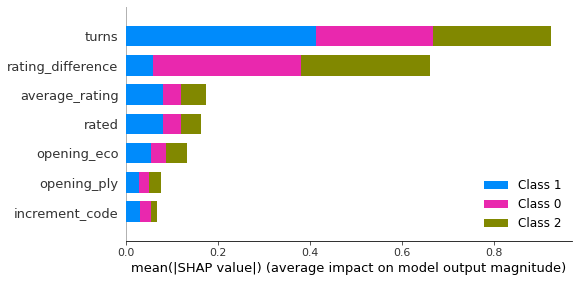

In [12]:
shap.summary_plot(shap_values, X_train)

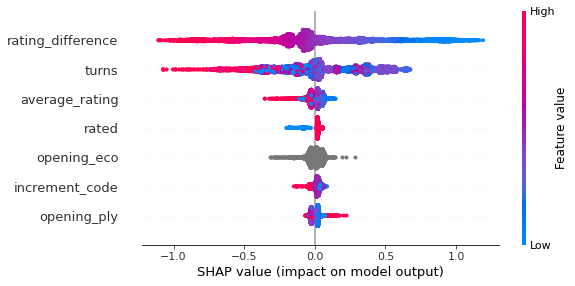

In [24]:
shap.summary_plot(shap_values[0], X_train)